Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Kats Changepoint Detection

* Kats General
  * `TimeSeriesData` params and methods: https://facebookresearch.github.io/Kats/api/kats.consts.html#kats.consts.TimeSeriesData
* Kats Detection
  * Kats detection official tutorial: https://github.com/facebookresearch/Kats/blob/main/tutorials/kats_202_detection.ipynb
  * Detectors: https://facebookresearch.github.io/Kats/api/kats.detectors.html
  * If your dataset has changepoints annotation, you can evaluate the detection algorithms: https://facebookresearch.github.io/Kats/api/kats.detectors.changepoint_evaluator.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from imp import reload
from datetime import datetime, timedelta
import sys
sys.path.append("../")

from kats.consts import TimeSeriesData
from kats.detectors.cusum_detection import CUSUMDetector
from kats.detectors.robust_stat_detection import RobustStatDetector
from kats.detectors.stat_sig_detector import StatSigDetectorModel, MultiStatSigDetectorModel

import warnings
warnings.filterwarnings("ignore")

In [2]:
mul_ts_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/multivar_ts.pkl')

print(mul_ts_df.shape)
mul_ts_df.head()

(8143, 6)


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [4]:
def plot_ts(ts, label, title):
    plt.figure(figsize=(20,3))
    fig = plt.plot(ts, label=label, color='blue')
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

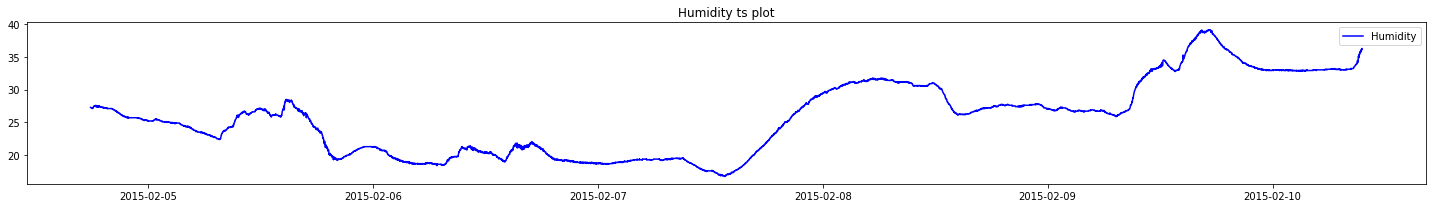

In [5]:
plot_ts(mul_ts_df['Humidity'], label='Humidity', title='Humidity ts plot')

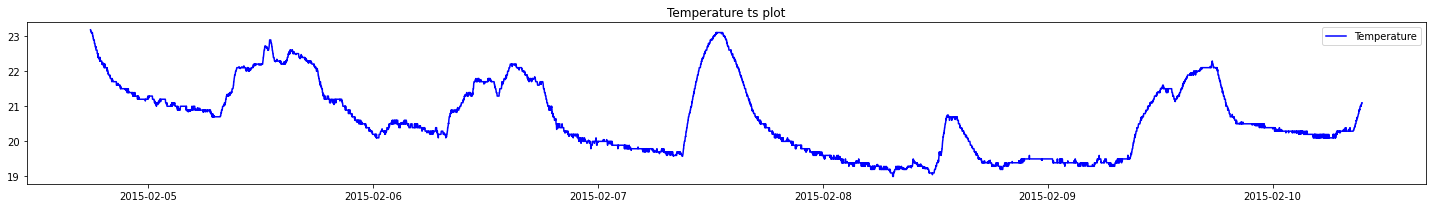

In [6]:
plot_ts(mul_ts_df['Temperature'], label='Temperature', title='Temperature ts plot')

In [3]:
# Covert to Kats required TimeSeriesData input
kats_ts_humidity = TimeSeriesData(mul_ts_df[['Humidity']].reset_index().rename(index=str, columns={'date': 'time'}))
print(len(kats_ts_humidity))

kats_ts_temp = TimeSeriesData(mul_ts_df[['Temperature']].reset_index().rename(index=str, columns={'date': 'time'}))
print(len(kats_ts_temp))

8143
8143


### CUSUMDetector

* https://facebookresearch.github.io/Kats/api/kats.detectors.cusum_detection.html

In [4]:
detector1 = CUSUMDetector(kats_ts_humidity)
detector2 = CUSUMDetector(kats_ts_temp)

#### Detect Single Changepoint

In [6]:
def plot_changepoint_detection(detector, args):
    change_point = detector.detector(**args)
    print(change_point)
    detector.plot(change_point, figsize=(20,3))

[CUSUMChangePoint(start_time: 2015-02-07 20:53:00, end_time: 2015-02-07 20:53:00, confidence: 1.0, direction: increase, index: 4502, delta: 9.043013542660614, regression_detected: True, stable_changepoint: True, mu0: 21.689192501295434, mu1: 30.732206043956047, llr: 8804.063613586877, llr_int: inf, p_value: 0.0, p_value_int: nan)]


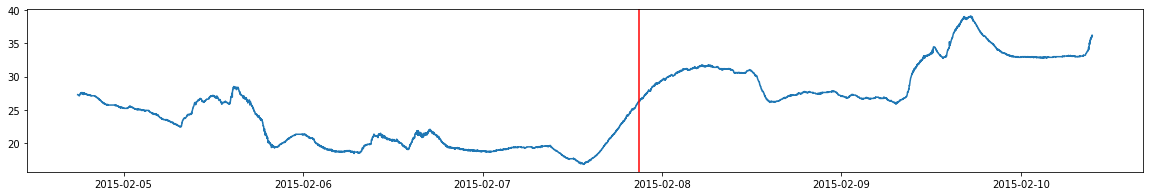

In [7]:
args = {'change_directions': ['increase'], 'threshold': 0.05}
plot_changepoint_detection(detector1, args)

[CUSUMChangePoint(start_time: 2015-02-04 20:51:59, end_time: 2015-02-04 20:51:59, confidence: 0.9977164557198448, direction: decrease, index: 181, delta: -1.4455983249154727, regression_detected: True, stable_changepoint: True, mu0: 27.144795787545792, mu1: 25.69919746263032, llr: 12.164053068347869, llr_int: inf, p_value: 0.002283544280155203, p_value_int: nan)]


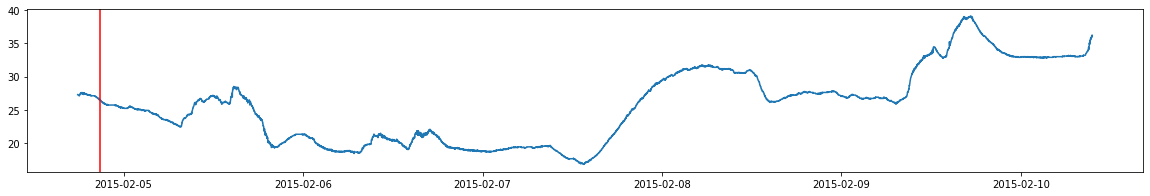

In [8]:
args = {'change_directions': ['decrease'], 'threshold': 0.05}
plot_changepoint_detection(detector1, args)

[]


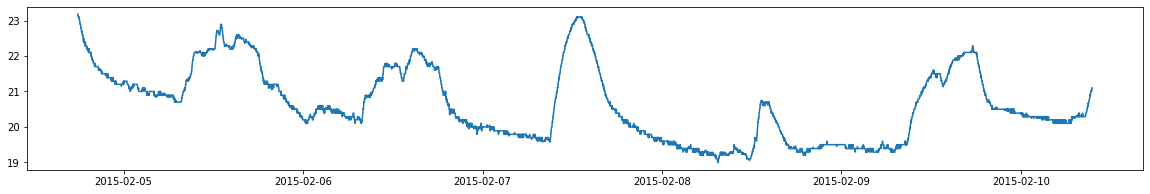

In [9]:
args = {'change_directions': ['increase'], 'threshold': 0.05}
plot_changepoint_detection(detector2, args)

[CUSUMChangePoint(start_time: 2015-02-07 17:12:59, end_time: 2015-02-07 17:12:59, confidence: 1.0, direction: decrease, index: 4282, delta: -1.0910530720975053, regression_detected: True, stable_changepoint: True, mu0: 21.136272005603548, mu1: 20.045218933506042, llr: 2755.0103618997027, llr_int: inf, p_value: 0.0, p_value_int: nan)]


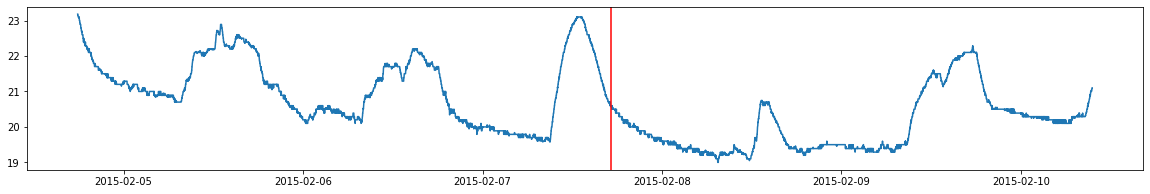

In [10]:
args = {'change_directions': ['decrease'], 'threshold': 0.05}
plot_changepoint_detection(detector2, args)

[CUSUMChangePoint(start_time: 2015-02-05 20:44:59, end_time: 2015-02-05 20:44:59, confidence: 1.0, direction: decrease, index: 1614, delta: -1.2721139054168802, regression_detected: True, stable_changepoint: True, mu0: 21.63889938080495, mu1: 20.36678547538807, llr: 2330.0002105565036, llr_int: 968.7923902430808, p_value: 0.0, p_value_int: 0.0)]


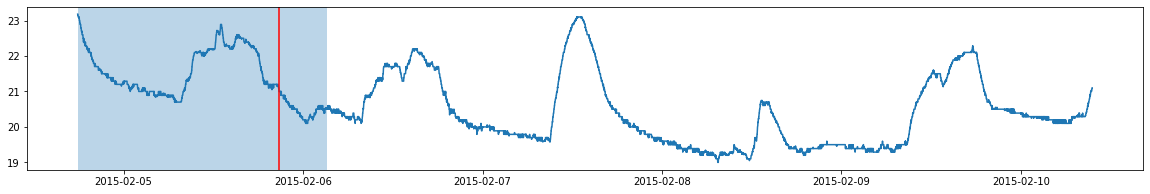

In [11]:
args = {'change_directions': ['decrease'], 'threshold': 0.05, 'interest_window': [0, 2000]}
plot_changepoint_detection(detector2, args)

#### Detect Multiple Changepoints with Sliding Windows

In [28]:
def get_all_changepoints(ts, window_size, step, args):
    ts_len = len(ts)
    
    if ts_len <= window_size:
        raise ValueError('window_size needs to be smaller than the length of the time series')
    if window_size + step > ts_len:
        raise ValueError('window_size + step should not be larger than the length of the time series')
        
    changepoints = []
        
    for start_idx in range(0, ts_len-window_size, step):
        window_ts = ts[start_idx : start_idx + window_size]
        changepoints += CUSUMDetector(window_ts).detector(**args)
    return changepoints


def plot_multi_changepoints(detector, changepoints):
    detector.detector()
    detector.plot(changepoints, figsize=(20,3))

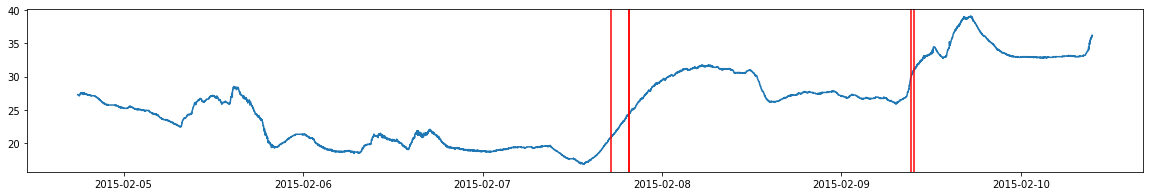

In [37]:
args = {'change_directions': ['increase'], 'threshold': 0.05}
changepoints = get_all_changepoints(kats_ts_humidity, 2000, 800, args)
plot_multi_changepoints(detector1, changepoints)

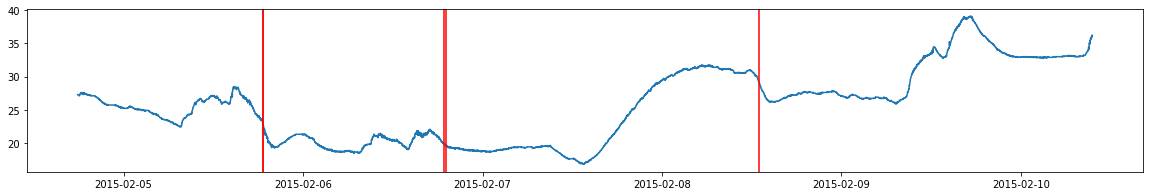

In [38]:
args = {'change_directions': ['decrease'], 'threshold': 0.05}
changepoints = get_all_changepoints(kats_ts_humidity, 2000, 800, args)
plot_multi_changepoints(detector1, changepoints)

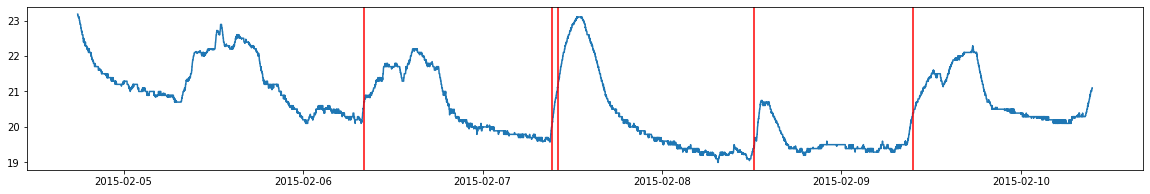

In [39]:
args = {'change_directions': ['increase'], 'threshold': 0.05}
changepoints = get_all_changepoints(kats_ts_temp, 2000, 800, args)
plot_multi_changepoints(detector2, changepoints)

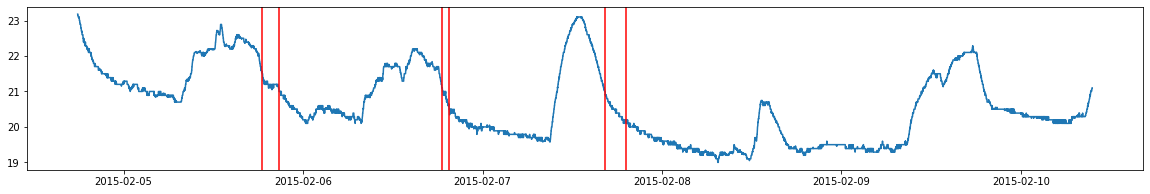

In [40]:
args = {'change_directions': ['decrease'], 'threshold': 0.05}
changepoints = get_all_changepoints(kats_ts_temp, 2000, 800, args)
plot_multi_changepoints(detector2, changepoints)

### RobustStatDetector

In [20]:
detector3 = RobustStatDetector(kats_ts_humidity)
detector4 = RobustStatDetector(kats_ts_temp)

#### Detect Single Changepoint

[TimeSeriesChangePoint(start_time: 2015-02-08T07:14:00.000000000, end_time: 2015-02-08T07:14:00.000000000, confidence: 0.9900477265417903)]


<AxesSubplot:>

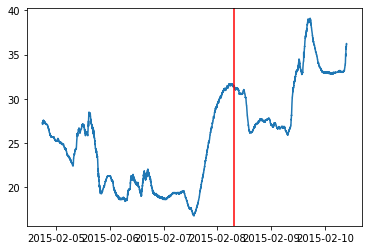

In [60]:
changepoints = detector3.detector(p_value_cutoff=0.01, smoothing_window_size=500, comparison_window=1000)

print(changepoints)
detector3.plot(changepoints)

[TimeSeriesChangePoint(start_time: 2015-02-09T03:02:00.000000000, end_time: 2015-02-09T03:02:00.000000000, confidence: 0.9900130111091532)]


<AxesSubplot:>

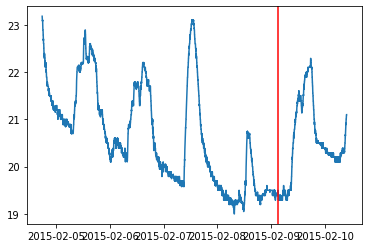

In [50]:
changepoints = detector4.detector(p_value_cutoff=0.01, smoothing_window_size=2000, comparison_window=2000)

print(changepoints)
detector4.plot(changepoints)

#### Detect Multiple Changepoints

<AxesSubplot:>

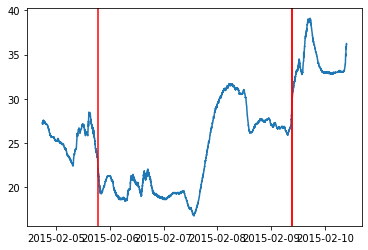

In [68]:
changepoints = detector3.detector(p_value_cutoff=1e-7, comparison_window=10)

detector3.plot(changepoints)

<AxesSubplot:>

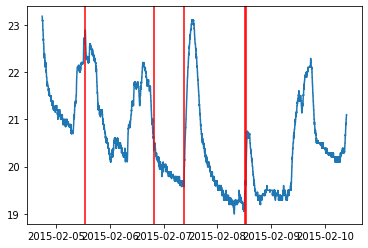

In [61]:
changepoints = detector4.detector(p_value_cutoff=1e-5, comparison_window=2)

detector4.plot(changepoints)

### StatSigDetector

* https://facebookresearch.github.io/Kats/api/kats.detectors.stat_sig_detector.html
* Although it doesn't detect changepoint, given 2 periods of ts, it's trying to tell whether they are significantly different. However, current problem is, as you can see below, I can't get the detected results shown...

#### Univariate ts

In [12]:
# Use some detected changepoint to split the time series
detector1 = CUSUMDetector(kats_ts_humidity)
detector2 = CUSUMDetector(kats_ts_temp)

args1 = {'change_directions': ['increase'], 'threshold': 0.05}
args2 = {'change_directions': ['decrease'], 'threshold': 0.05}

cp1 = detector1.detector(**args1)
print(cp1)
cp2 = detector2.detector(**args2)
print(cp2)

[CUSUMChangePoint(start_time: 2015-02-07 20:53:00, end_time: 2015-02-07 20:53:00, confidence: 1.0, direction: increase, index: 4502, delta: 9.043013542660614, regression_detected: True, stable_changepoint: True, mu0: 21.689192501295434, mu1: 30.732206043956047, llr: 8804.063613586877, llr_int: inf, p_value: 0.0, p_value_int: nan)]
[CUSUMChangePoint(start_time: 2015-02-07 17:12:59, end_time: 2015-02-07 17:12:59, confidence: 1.0, direction: decrease, index: 4282, delta: -1.0910530720975053, regression_detected: True, stable_changepoint: True, mu0: 21.136272005603548, mu1: 20.045218933506042, llr: 2755.0103618997027, llr_int: inf, p_value: 0.0, p_value_int: nan)]


In [26]:
kats_ts_humidity_control = kats_ts_humidity[0:4503]
kats_ts_humidity_test = kats_ts_humidity[4503:]

kats_ts_temp_control = kats_ts_temp[0:4283]
kats_ts_temp_test = kats_ts_temp[4283:]

ss_detect1 = StatSigDetectorModel(n_control=len(kats_ts_humidity_control), n_test=len(kats_ts_humidity_test), time_unit='H')
ss_detect2 = StatSigDetectorModel(n_control=len(kats_ts_temp_control), n_test=len(kats_ts_temp_test), time_unit='H')

In [31]:
ssd1 = ss_detect1.fit_predict(data=kats_ts_humidity_test, historical_data=kats_ts_humidity_control)
ssd1

In [ ]:
ss_detect1.visualize()  # Got "ValueError: Call fit_predict() before visualize()"